In [1]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision
import pandas as pd
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

In [2]:
import seaborn as sns
from collections import Counter
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import random
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import LabelEncoder

# Loading & Visualization

In [3]:
df = pd.read_csv("data/planet\planet/train_classes.csv") # Adjust as needed
df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [4]:
all_tags = set()
for tags in df['tags'].str.split():
    all_tags.update(tags)
print(all_tags)

{'primary', 'blooming', 'clear', 'haze', 'habitation', 'road', 'cloudy', 'partly_cloudy', 'artisinal_mine', 'selective_logging', 'agriculture', 'blow_down', 'cultivation', 'slash_burn', 'conventional_mine', 'water', 'bare_ground'}


In [5]:
tag_to_idx = {tag: idx for idx, tag in enumerate(sorted(all_tags))}
idx_to_tag = {idx: tag for tag, idx in tag_to_idx.items()}
print(tag_to_idx)
print(len(tag_to_idx))

{'agriculture': 0, 'artisinal_mine': 1, 'bare_ground': 2, 'blooming': 3, 'blow_down': 4, 'clear': 5, 'cloudy': 6, 'conventional_mine': 7, 'cultivation': 8, 'habitation': 9, 'haze': 10, 'partly_cloudy': 11, 'primary': 12, 'road': 13, 'selective_logging': 14, 'slash_burn': 15, 'water': 16}
17


## Imbalance Metrics

In [76]:
# Based on https://link.springer.com/chapter/10.1007/978-3-642-40846-5_16 

# Calculate h(y, Yi)
def h(y, Yi):
    return 1 if y in Yi else 0

# Calculate IRperLabel for each label y
def calculate_IRperLabel(all_labels, df):
    IR = {}
    # Split tags into lists of labels
    df['label_list'] = df['tags'].apply(lambda x: x.split())
    for y in all_labels:
        label_counts = [sum(h(y, Yi) for Yi in df['label_list'])]
        majority_label_count = sum(label_counts)
        
        # Get the number of labels in the dataset
        IR[y] = majority_label_count / len(df) if len(df) > 0 else 0

    return IR

# Calculate MeanIR (average imbalance ratio)
def calculate_MeanIR(IR):
    return np.mean(list(IR.values()))

# Calculate CVIR (coefficient of variation of imbalance ratio)
def calculate_CVIR(IR, MeanIR):
    mean_squared_diff = np.mean([(val - MeanIR)**2 for val in IR.values()])
    return np.sqrt(mean_squared_diff) / MeanIR if MeanIR != 0 else 0


In [68]:
def plot_spread(data):
    # Flatten the list of labels
    all_tags = data['tags'].apply(lambda x: x.split() if isinstance(x, str) else x)
    flattened_tags = [tag for sublist in all_tags for tag in sublist]

    # Convert to a DataFrame for easy handling
    tag_df = pd.DataFrame(flattened_tags, columns=['tag'])

    # Sort tags alphabetically
    sorted_tag_counts = tag_df['tag'].value_counts().sort_index()  # Sort alphabetically by tag
    sorted_tag_df = pd.DataFrame({'tag': sorted_tag_counts.index, 'count': sorted_tag_counts.values})

    # Plot the distribution horizontally
    plt.figure(figsize=(12, 6))  # Increase figure size to accommodate labels
    sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data

    # Add labels and title
    plt.title('Tag Distribution in Multi-Tag Dataset', fontsize=16)
    plt.xlabel('Count', fontsize=14)
    plt.ylabel('Tags', fontsize=14)

    # Adjust label sizes and positioning
    plt.tight_layout()

    # Display the plot
    plt.show()

def get_std_dev(data):
    tag_counts = Counter(tag for tags in data['tags'] for tag in tags)
    frequencies = list(tag_counts.values())
    imbalance_std = np.std(frequencies)
    print(f"Standard Deviation of Tag Frequencies: {imbalance_std}")


C:\Users\xxpur\AppData\Local\Temp\ipykernel_26716\3117131438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


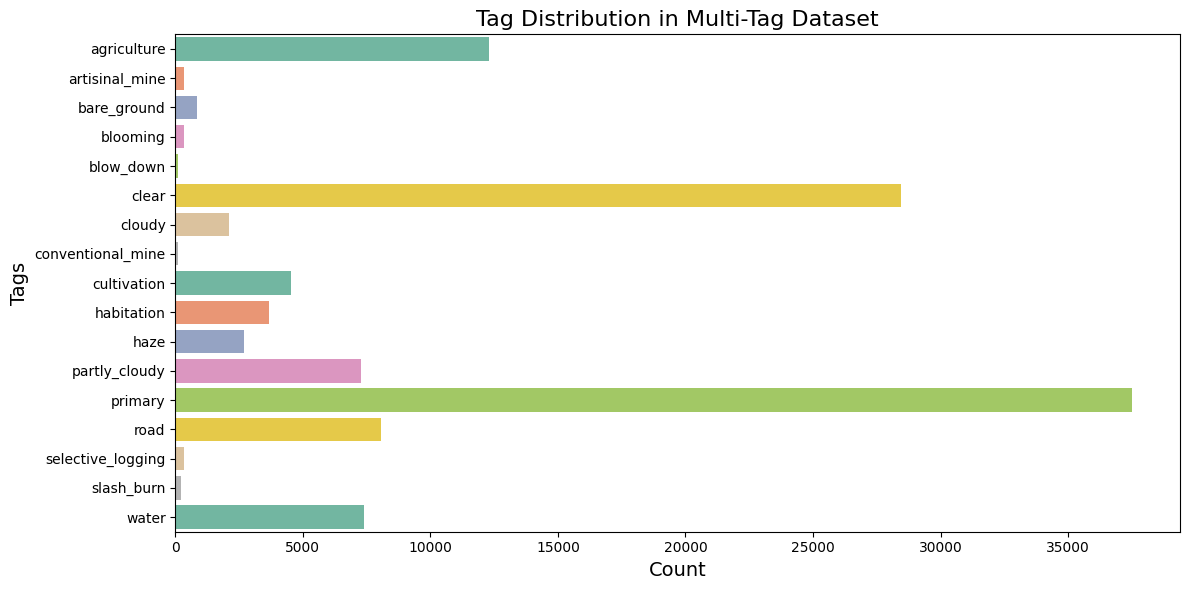

Standard Deviation of Tag Frequencies: 37670.58183190001
IRperLabel: {'primary': 0.9267274389189456, 'blooming': 0.00820178364090022, 'clear': 0.702364188838657, 'haze': 0.06662713999851776, 'habitation': 0.090417253390647, 'road': 0.1993873366436918, 'cloudy': 0.05160700610192939, 'partly_cloudy': 0.1793769608933027, 'artisinal_mine': 0.00837471281405173, 'selective_logging': 0.008399416981644803, 'agriculture': 0.3042318239086934, 'blow_down': 0.0024210084241211493, 'cultivation': 0.11060055831418761, 'slash_burn': 0.005163171026952247, 'conventional_mine': 0.002470416759307295, 'water': 0.18308258603226366, 'bare_ground': 0.021294992465228885}
MeanIR: 0.16886751736194366
CVIR: 1.5019480501275149


In [77]:
plot_spread(df)
get_std_dev(df)
IR = calculate_IRperLabel(all_tags, df)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

# Generation

In [9]:
# Create validation group before anything happens
train, val = train_test_split(df, test_size=0.1)
print(train.shape)
print(val.shape)

(36431, 3)
(4048, 3)


In [ ]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        # if type(csv_file) != str:
        #     self.df = csv_file
        # else:
        #     self.df = pd.read_csv(csv_file)
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        if "aug" in img_name:
            img_path = os.path.join("data/augmented_images/", f"{img_name}.jpg")
            #img_path = os.path.join(self.img_dir, f"{img_name}")
        else:
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        tags = self.df.iloc[idx, 1].split()
        labels = torch.zeros(len(tag_to_idx))
        for tag in tags:
            labels[tag_to_idx[tag]] = 1
        
        return image, labels

In [11]:
import albumentations as A
import cv2

augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.2),
    A.RandomGamma(p=0.3),
])

d:\Anaconda_Environments\For_ML\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Undersampling

### Label Powerset based Random Undersampling (LP-RUS)

#### Setup (For both LP-RUS and LP-ROS)

In [ ]:
from skmultilearn.problem_transform import LabelPowerset

X = train["image_name"].values
y = train["tags"].values
y_binary = np.zeros((len(y), len(tag_to_idx)), dtype=int)

# Populate the binary matrix
for i, tags in enumerate(y):
    for tag in tags.split():  # Split tags by space
        tag_id = tag_to_idx[tag]
        y_binary[i, tag_id] = 1

print(y.shape) # (36431, )
print(y_binary.shape) # (36431, 17)
#print(y[0])
X = X.reshape(-1, 1)
print(X.shape)

lp = LabelPowerset()
X_transformed = X
y_transformed = lp.transform(y_binary)
print(X_transformed.shape)
y_transformed = y.reshape(-1,1)
print(y_transformed.shape)
#print(y_transformed)

(36431,)
(36431, 17)
(36431, 1)
(36431, 1)
(36431, 1)


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Apply random undersampling
ros = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = ros.fit_resample(X_transformed, y_transformed)

df_undersampled = pd.DataFrame(X_undersampled)

# Add the decoded labels as a column to the DataFrame
df_undersampled['tags'] = y_undersampled
print(df_undersampled)

[['agriculture partly_cloudy primary']
 ['agriculture clear primary']
 ['clear primary']
 ...
 ['clear cultivation primary']
 ['agriculture clear primary road water']
 ['agriculture clear cultivation primary road water']]
               0                                               tags
0    train_20674  agriculture artisinal_mine bare_ground clear p...
1     train_2330  agriculture artisinal_mine bare_ground clear p...
2     train_9528  agriculture artisinal_mine clear conventional_...
3     train_8330  agriculture artisinal_mine clear cultivation h...
4    train_38796  agriculture artisinal_mine clear cultivation h...
..           ...                                                ...
424   train_1857                   partly_cloudy primary slash_burn
425  train_20958                        partly_cloudy primary water
426    train_340                           partly_cloudy road water
427  train_34575                                partly_cloudy water
428  train_24448              

C:\Users\xxpur\AppData\Local\Temp\ipykernel_26716\3117131438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


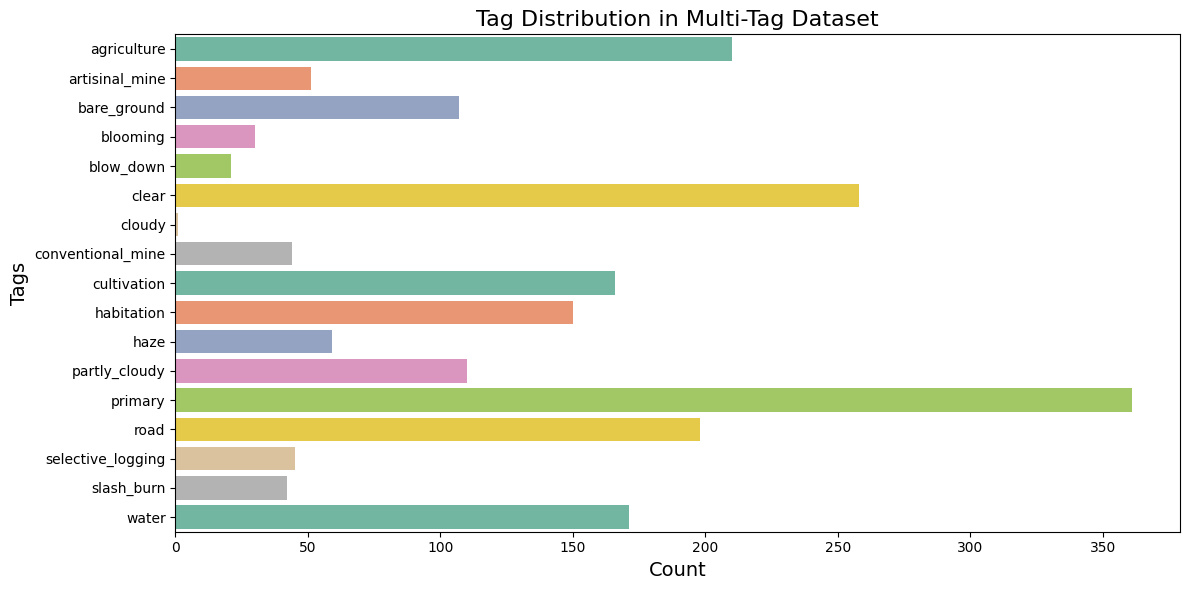

Standard Deviation of Tag Frequencies: 591.4097987812833
IRperLabel: {'primary': 0.8414918414918415, 'blooming': 0.06993006993006994, 'clear': 0.6013986013986014, 'haze': 0.13752913752913754, 'habitation': 0.34965034965034963, 'road': 0.46153846153846156, 'cloudy': 0.002331002331002331, 'partly_cloudy': 0.2564102564102564, 'artisinal_mine': 0.11888111888111888, 'selective_logging': 0.1048951048951049, 'agriculture': 0.48951048951048953, 'blow_down': 0.04428904428904429, 'cultivation': 0.3473193473193473, 'slash_burn': 0.0979020979020979, 'conventional_mine': 0.10256410256410256, 'water': 0.3986013986013986, 'bare_ground': 0.2494172494172494}
MeanIR: 0.27492115727409844
CVIR: 0.8077195479197075


In [14]:
plot_spread(df_undersampled)
get_std_dev(df_undersampled)
IR = calculate_IRperLabel(all_tags, df_undersampled)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

### Multi Label Random Undersampling (ML-RUS)

## Oversampling

### Label Powerset based Random Oversampling (LP-ROS)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

# Apply random oversampling
ros = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = ros.fit_resample(X_transformed, y_transformed)

df_oversampled = pd.DataFrame(X_oversampled)

# Add the decoded labels as a column to the DataFrame
df_oversampled['tags'] = y_oversampled
print(df_oversampled)

                   0                               tags
0        train_16761  agriculture partly_cloudy primary
1         train_6527          agriculture clear primary
2         train_8682                      clear primary
3        train_10792  agriculture partly_cloudy primary
4        train_20989                       haze primary
...              ...                                ...
5264254  train_24448                              water
5264255  train_24448                              water
5264256  train_24448                              water
5264257  train_24448                              water
5264258  train_24448                              water

[5264259 rows x 2 columns]


C:\Users\xxpur\AppData\Local\Temp\ipykernel_32304\2573084261.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


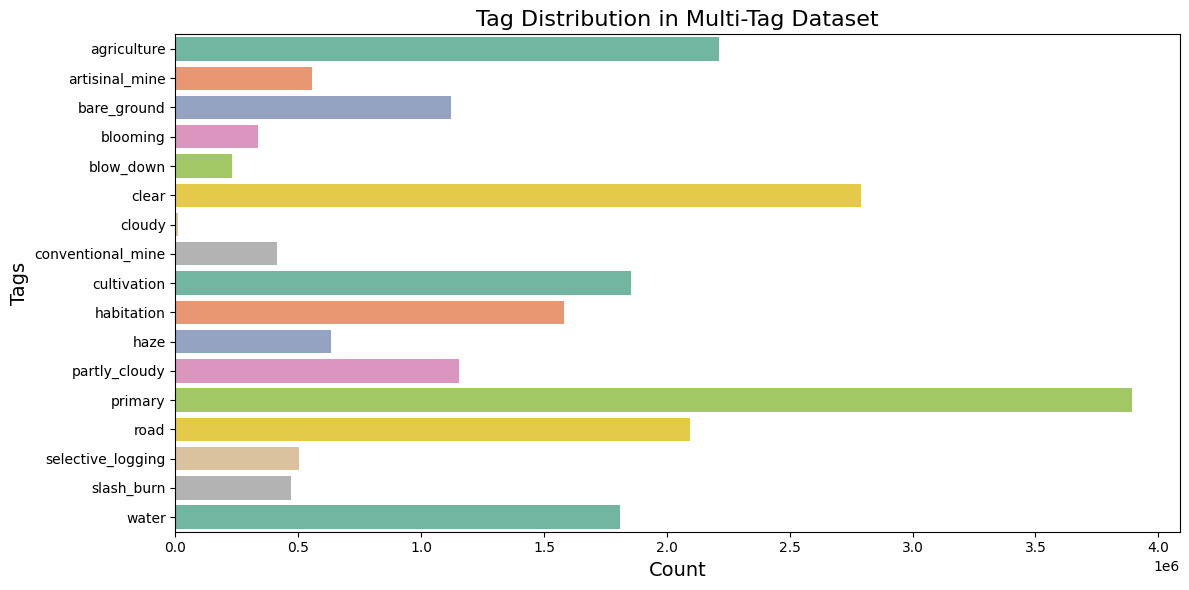

Standard Deviation of Tag Frequencies: 6321737.504295572


In [160]:
plot_spread(df_oversampled)
get_std_dev(df_oversampled)
# IR = calculate_IRperLabel(all_tags, df_oversampled)
# MeanIR = calculate_MeanIR(IR)
# CVIR = calculate_CVIR(IR, MeanIR)

# print("IRperLabel:", IR)
# print("MeanIR:", MeanIR)
# print("CVIR:", CVIR)

### Oversampling with Data Augmentations, piggybacked on LP-ROS

In [ ]:
original_indices = ros.sample_indices_  # These indices show how the resampling occurred
# Separate new samples

new_sample_mask = ~np.isin(np.arange(len(X_oversampled)), original_indices)
# Augmentation pipeline
augmentation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.2),
    A.RandomGamma(p=0.3),
])

# Augment the oversampled images
# augmented_images = []
# augmented_labels = []

for idx, row in df_oversampled.iterrows():
    # Load the image from its path
    #print(row[0])
    image_path = "data/planet\planet/train-jpg/" + row[0] + ".jpg"
    #print(image_path)
    image = cv2.imread(image_path)  # Load image using OpenCV
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply augmentations
    augmented = augmentation_pipeline(image=image)
    augmented_image = augmented['image']

    # Save augmented image
    augmented_image_dir = "data/augmented_images"
    new_filename = f"aug_{idx}_{row[0]}.jpg"
    save_path = os.path.join(augmented_image_dir, new_filename)
    #print(save_path)
    cv2.imwrite(save_path, augmented_image)
    new_filename = new_filename[:-4]

    # Append to DataFrame
    #df = df.append({'image': new_filename, 'tags': row['tags']}, ignore_index=True)
    df.loc[len(df)] = {'image_name': new_filename, 'tags': tags}

    # Save or store the augmented image
    # You could save augmented_image to disk or keep it in memory
    # augmented_images.append(new_filename)
    # augmented_labels.append(row['tags'])

# Create a new DataFrame with the augmented data
#df_augmented = pd.DataFrame({'image_data': augmented_images, 'tags': augmented_labels})


KeyboardInterrupt: 

### Multi Label Random Oversampling (ML-ROS)

In [ ]:
# Function to calculate Imbalance Ratio (IR)
def calculate_imbalance_ratio(y_binary):
    label_counts = np.sum(y_binary, axis=0)  # Sum across rows to count label occurrences
    total_samples = len(y_binary)
    imbalance_ratios = label_counts / total_samples  # IR = count of label / total samples
    return imbalance_ratios

# Function to clone minority samples
def ml_ros_clone(X, y_binary, target_size):
    #print(y_binary)
    current_size = len(X)
    samples_to_add = target_size - current_size
    
    # Calculate imbalance ratios
    imbalance_ratios = calculate_imbalance_ratio(y_binary)
    mean_ir = np.mean(imbalance_ratios)
    
    # Identify minority label sets based on imbalance ratio
    minority_indices = []
    for i in range(len(y_binary)): # NOTE: This is not random!
        # Check if the sample belongs to a minority class (based on IR)
        label_ir = np.sum(y_binary[i]) / len(y_binary[i])  # Sum of labels divided by number of labels
        if label_ir < mean_ir:
            minority_indices.append(i)
    
    # Clone the minority samples
    while samples_to_add > 0:
        for i in minority_indices:
            if samples_to_add <= 0:
                break
            X = np.append(X, X[i])  # Clone the image name (image name is being duplicated)
            y_binary = np.vstack([y_binary, y_binary[i]])  # Clone the corresponding label vector
            samples_to_add -= 1
    
    print(X.shape)
    return X, y_binary

# Define the target size (desired number of samples after oversampling)
target_size = len(X) * 2  # Double the size of the dataset as an example

# Apply ML-ROS to clone minority samples
X_resampled, y_resampled = ml_ros_clone(X, y_binary, target_size)

print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)

# Convert resampled binary labels (y_resampled) back to tag strings
ML_ROS_resampled_data = pd.DataFrame({
    'image_name': X_resampled,
    'tags': [' '.join([k for k, v in tag_to_idx.items() if row[v] == 1]) for row in y_resampled]
})

print(ML_ROS_resampled_data)


(72862,)
Resampled X shape: (72862,)
Resampled y shape: (72862, 17)
        image_name                               tags
0      train_16761  agriculture partly_cloudy primary
1       train_6527          agriculture clear primary
2       train_8682                      clear primary
3      train_10792  agriculture partly_cloudy primary
4      train_20989                       haze primary
...            ...                                ...
72857  train_37946                      clear primary
72858    train_395              partly_cloudy primary
72859  train_36495                      clear primary
72860  train_19718                       haze primary
72861   train_1174                      clear primary

[72862 rows x 2 columns]


### Oversampling with Data Augmentations, piggybacked on ML-ROS

In [ ]:
# Function to calculate Imbalance Ratio (IR)
def calculate_imbalance_ratio(y_binary):
    label_counts = np.sum(y_binary, axis=0)  # Sum across rows to count label occurrences
    total_samples = len(y_binary)
    imbalance_ratios = label_counts / total_samples  # IR = count of label / total samples
    return imbalance_ratios

# Function to clone minority samples
def ml_ros_clone_augment(X, y_binary, target_size):
    
    # Augmentation pipeline
    augmentation_pipeline = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.GaussianBlur(p=0.2),
        A.RandomGamma(p=0.3),
    ])

    X = np.reshape(X,-1)
    #print(y_binary)
    current_size = len(X)
    samples_to_add = target_size - current_size
    
    # Calculate imbalance ratios
    imbalance_ratios = calculate_imbalance_ratio(y_binary)
    mean_ir = np.mean(imbalance_ratios)
    
    # Identify minority label sets based on imbalance ratio
    minority_indices = []
    for i in range(len(y_binary)): # NOTE: This is not random!
        # Check if the sample belongs to a minority class (based on IR)
        label_ir = np.sum(y_binary[i]) / len(y_binary[i])  # Sum of labels divided by number of labels
        if label_ir < mean_ir:
            minority_indices.append(i)
    
    # Clone the minority samples
    while samples_to_add > 0:
        for i in minority_indices:
            if samples_to_add <= 0:
                break

            # Create new augmented image
            image_path = "data/planet\planet/train-jpg/" + X[i] + ".jpg"
            image = cv2.imread(image_path)  # Load image using OpenCV
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply augmentations
            augmented = augmentation_pipeline(image=image)
            augmented_image = augmented['image']

            # Save augmented image
            augmented_image_dir = "data/augmented_images"
            new_filename = f"aug_{X[i]}.jpg"
            save_path = os.path.join(augmented_image_dir, new_filename)
            #print(save_path)
            cv2.imwrite(save_path, augmented_image)
            #print('saved')
            new_filename = new_filename[:-4]
            #print(new_filename)

            X = np.append(X, [new_filename])  # Clone the image name (image name is being duplicated)
            y_binary = np.vstack([y_binary, y_binary[i]])  # Clone the corresponding label vector
            samples_to_add -= 1
    
    print(X.shape)
    return X, y_binary

# Define the target size (desired number of samples after oversampling)
target_size = len(X) * 2  # Double the size of the dataset as an example

# Apply ML-ROS to clone minority samples
X_resampled, y_resampled = ml_ros_clone_augment(X, y_binary, target_size)

print("Resampled X shape:", X_resampled.shape)
print("Resampled y shape:", y_resampled.shape)

# Convert resampled binary labels (y_resampled) back to tag strings
ML_ROS_resampled_data = pd.DataFrame({
    'image_name': X_resampled,
    'tags': [' '.join([k for k, v in tag_to_idx.items() if row[v] == 1]) for row in y_resampled]
})

print(ML_ROS_resampled_data)


aug_train_8682
aug_train_20989
aug_train_19851
aug_train_33162
aug_train_23918
aug_train_26360
aug_train_5685
aug_train_32761
aug_train_2940
aug_train_32796
aug_train_29095
aug_train_40347
aug_train_1161
aug_train_38978
aug_train_21911
aug_train_11275
aug_train_15030
aug_train_30701
aug_train_23440
aug_train_19297
aug_train_12745
aug_train_25897
aug_train_25909
aug_train_19102
aug_train_10396
aug_train_18219
aug_train_11203
aug_train_12113
aug_train_10598
aug_train_905
aug_train_14932
aug_train_4784
aug_train_11733
aug_train_33113
aug_train_6600
aug_train_38023
aug_train_39994
aug_train_23420
aug_train_2737
aug_train_23375
aug_train_20372
aug_train_29403
aug_train_24655
aug_train_26399
aug_train_40015
aug_train_32947
aug_train_35063
aug_train_33612
aug_train_18318
aug_train_21277
aug_train_27811
aug_train_29638
aug_train_382
aug_train_24441
aug_train_33715
aug_train_19743
aug_train_14560
aug_train_13222
aug_train_33819
aug_train_35272
aug_train_893
aug_train_33482
aug_train_15840
aug_t

KeyboardInterrupt: 

C:\Users\xxpur\AppData\Local\Temp\ipykernel_26716\3117131438.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='tag', x='count', data=sorted_tag_df, palette='Set2')  # Use sorted data


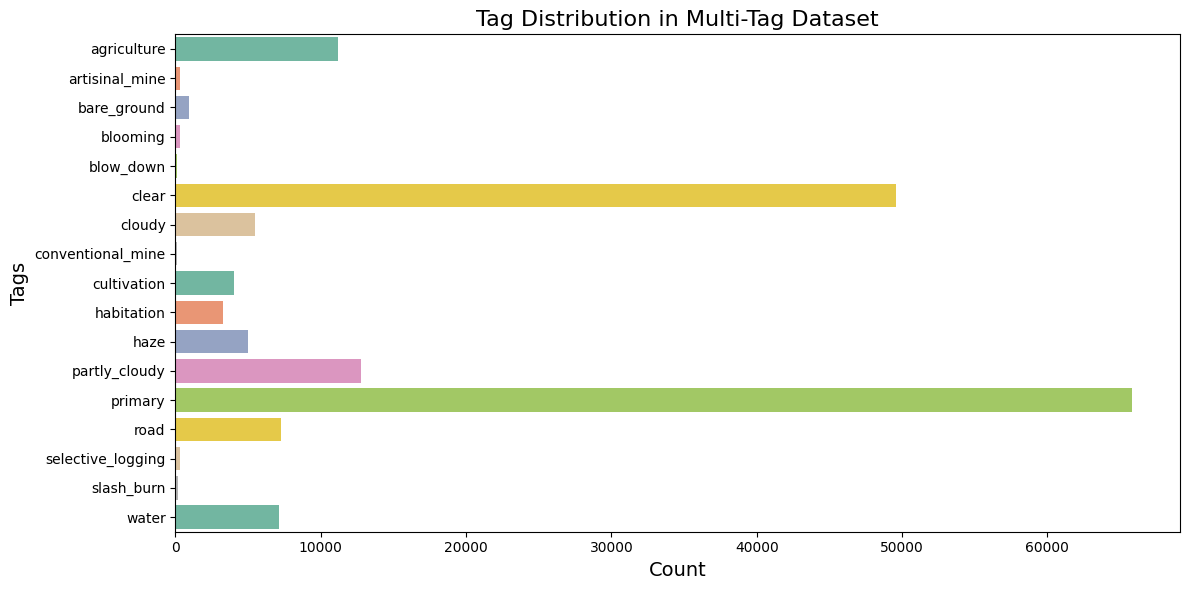

Standard Deviation of Tag Frequencies: 57439.55793978206
IRperLabel: {'primary': 0.9035574098981637, 'blooming': 0.004117372567319042, 'clear': 0.6804507150503691, 'haze': 0.06878757102467678, 'habitation': 0.04481073810765557, 'road': 0.09954434410255003, 'cloudy': 0.07510087562789931, 'partly_cloudy': 0.1756196645713815, 'artisinal_mine': 0.004089923416870248, 'selective_logging': 0.004144821717767835, 'agriculture': 0.15363289506189784, 'blow_down': 0.0011665888940737283, 'cultivation': 0.05535121187999231, 'slash_burn': 0.0026213938678597897, 'conventional_mine': 0.0012352117701957125, 'water': 0.09824050945623233, 'bare_ground': 0.012983448162279377}
MeanIR: 0.14032086442218733
CVIR: 1.7578954276649956


In [90]:
plot_spread(ML_ROS_resampled_data)
get_std_dev(ML_ROS_resampled_data)
IR = calculate_IRperLabel(all_tags, ML_ROS_resampled_data)
MeanIR = calculate_MeanIR(IR)
CVIR = calculate_CVIR(IR, MeanIR)

print("IRperLabel:", IR)
print("MeanIR:", MeanIR)
print("CVIR:", CVIR)

### SMOTE

In [ ]:
# Taken from https://www.kaggle.com/code/tolgadincer/upsampling-multilabel-data-with-mlsmote 

def get_tail_label(df: pd.DataFrame, ql=[0.05, 1.]) -> list:
    """
    Find the underrepresented targets.
    Underrepresented targets are those which are observed less than the median occurance.
    Targets beyond a quantile limit are filtered.
    """
    irlbl = df.sum(axis=0)
    irlbl = irlbl[(irlbl > irlbl.quantile(ql[0])) & ((irlbl < irlbl.quantile(ql[1])))]  # Filtering
    irlbl = irlbl.max() / irlbl
    threshold_irlbl = irlbl.median()
    tail_label = irlbl[irlbl > threshold_irlbl].index.tolist()
    return tail_label

def get_minority_samples(X: pd.DataFrame, y: pd.DataFrame, ql=[0.05, 1.]):
    """
    return
    X_sub: pandas.DataFrame, the feature vector minority dataframe
    y_sub: pandas.DataFrame, the target vector minority dataframe
    """
    tail_labels = get_tail_label(y, ql=ql)
    index = y[y[tail_labels].apply(lambda x: (x == 1).any(), axis=1)].index.tolist()
    
    X_sub = X[X.index.isin(index)].reset_index(drop = True)
    y_sub = y[y.index.isin(index)].reset_index(drop = True)
    return X_sub, y_sub

def nearest_neighbour(X: pd.DataFrame, neigh) -> list:
    """
    Give index of 10 nearest neighbor of all the instance
    
    args
    X: np.array, array whose nearest neighbor has to find
    
    return
    indices: list of list, index of 5 NN of each element in X
    """
    nbs = NearestNeighbors(n_neighbors=neigh, metric='euclidean', algorithm='kd_tree').fit(X)
    euclidean, indices = nbs.kneighbors(X)
    return indices

def MLSMOTE(X, y, n_sample, neigh=5):
    """
    Give the augmented data using MLSMOTE algorithm
    
    args
    X: pandas.DataFrame, input vector DataFrame
    y: pandas.DataFrame, feature vector dataframe
    n_sample: int, number of newly generated sample
    
    return
    new_X: pandas.DataFrame, augmented feature vector data
    target: pandas.DataFrame, augmented target vector data
    """
    indices2 = nearest_neighbour(X, neigh=5)
    n = len(indices2)
    new_X = np.zeros((n_sample, X.shape[1]))
    target = np.zeros((n_sample, y.shape[1]))
    for i in range(n_sample):
        reference = random.randint(0, n-1)
        neighbor = random.choice(indices2[reference, 1:])
        all_point = indices2[reference]
        nn_df = y[y.index.isin(all_point)]
        ser = nn_df.sum(axis = 0, skipna = True)
        target[i] = np.array([1 if val > 0 else 0 for val in ser])
        ratio = random.random()
        gap = X.loc[reference,:] - X.loc[neighbor,:]
        new_X[i] = np.array(X.loc[reference,:] + ratio * gap)
    new_X = pd.DataFrame(new_X, columns=X.columns)
    target = pd.DataFrame(target, columns=y.columns)
    return new_X, target

# Testing

In [121]:
# ResNet & DenseNet
# transform = transforms.Compose([
#     transforms.Resize(256),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

# EfficientNet_b1
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(240),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [122]:
df_to_load = ML_ROS_resampled_data

dataset = MultiLabelImageDataset(df_to_load, img_dir="data/planet\planet/train-jpg", transform=transform)
train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=0.1, random_state=42)
# Since valiation split already done above with original data so no need

# # Only quick testing
#train_idx_small = train_idx[:1000]  # First 1000 training samples
#test_idx_small = test_idx[:200]  # First 200 testing samples

#train_idx_small = train_idx[:32787] 
#test_idx_small = test_idx[:3644] 

#train_dataset = Subset(dataset, train_idx_small)
#test_dataset = Subset(dataset, test_idx_small)
train_dataset = Subset(dataset, list(range(len(df_to_load))))
val_dataset = MultiLabelImageDataset(val, img_dir="data/planet\planet/train-jpg", transform=transform)
val_dataset = Subset(val_dataset, list(range(len(val))))

#train_dataset = Subset(dataset, train_idx)
#test_dataset = Subset(dataset, test_idx)

print(len(train_idx))
print(len(test_idx))



batch_size = 8
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

65575
7287


In [93]:
import torchvision.models as models
from torch import nn

num_classes = 17

def EfficientNetClassifier(num_classes):
    # load a pre-trained model
    model_ft = models.efficientnet_b1(weights='DEFAULT')
    # num_ftrs = model_ft.classifier.in_features
    
    # freeze all the parameters in the network except the final layer
    # for param in model_ft.parameters():
    #     param.requires_grad = False
    
    # replace the last fully connected layer
    model_ft.classifier = nn.Linear(1280, num_classes)
    return model_ft

In [117]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

model = EfficientNetClassifier(num_classes)
model.to(device)
#model

Using cuda device


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [44]:
def train_loop(dataloader, val_dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 64 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

        if batch % 256 == 0:
            val_loop(val_dataloader, model, loss_fn)


def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    test_loss /= num_batches
    f2 /= num_batches
    
    print(f"Test Error: \n f2 score: {f2:.5f}, avg loss: {test_loss:>8f} \n")
    return f2, test_loss

def val_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    val_loss, f2 = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred, y).item()

            # calculate f2 score
            pred_tags = torch.sigmoid(pred).cpu().numpy() > 0.24
            true_tags = y.cpu().numpy()
            f2 += fbeta_score(true_tags, pred_tags, beta=2, average='micro')

    val_loss /= num_batches
    f2 /= num_batches
    
    print(f"Val Error: \n f2 score: {f2:.5f}, avg loss: {val_loss:>8f} \n")
    return f2, val_loss


In [45]:
learning_rate = 0.0001
epochs = 5

In [124]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
all_loss = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, val_dataloader, model, loss_fn, optimizer)
    #f2, test_loss = test_loop(test_dataloader, model, loss_fn)
    val_loop(val_dataloader, model, loss_fn)
    #all_loss.append(test_loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.638112  [    8/72862]
Val Error: 
 f2 score: 0.89469, avg loss: 0.105325 

loss: 0.094880  [  520/72862]
loss: 0.103024  [ 1032/72862]
loss: 0.197930  [ 1544/72862]
loss: 0.081788  [ 2056/72862]
Val Error: 
 f2 score: 0.89221, avg loss: 0.108491 

loss: 0.046436  [ 2568/72862]
loss: 0.052761  [ 3080/72862]
loss: 0.066032  [ 3592/72862]
loss: 0.123380  [ 4104/72862]
Val Error: 
 f2 score: 0.89673, avg loss: 0.104345 

loss: 0.091921  [ 4616/72862]
loss: 0.038488  [ 5128/72862]
loss: 0.054554  [ 5640/72862]
loss: 0.034915  [ 6152/72862]
Val Error: 
 f2 score: 0.89646, avg loss: 0.103467 

loss: 0.040792  [ 6664/72862]
loss: 0.098546  [ 7176/72862]
loss: 0.107211  [ 7688/72862]
loss: 0.034479  [ 8200/72862]
Val Error: 
 f2 score: 0.90723, avg loss: 0.094788 

loss: 0.005464  [ 8712/72862]
loss: 0.070617  [ 9224/72862]
loss: 0.095119  [ 9736/72862]
loss: 0.028885  [10248/72862]
Val Error: 
 f2 score: 0.90276, avg loss: 0.098065 

loss: 0.1373

KeyboardInterrupt: 